In [1]:
from itertools import islice
import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib.pyplot import plot
from ipywidgets import interact, IntSlider

In [2]:
from longstaff_schwartz.stochastic_process import GeometricBrownianMotion

In [3]:
rnd = RandomState(seed=1234)

In [4]:
t = np.linspace(0, 3, 4)
n = 8
r = 0.06

In [5]:
X = np.array(
    [
        [1.00, 1.09, 1.08, 1.34],
        [1.00, 1.16, 1.26, 1.54],
        [1.00, 1.22, 1.07, 1.03],
        [1.00, 0.93, 0.97, 0.92],
        [1.00, 1.11, 1.56, 1.52],
        [1.00, 0.76, 0.77, 0.90],
        [1.00, 0.92, 0.84, 1.01],
        [1.00, 0.88, 1.22, 1.34],
    ]
).T
X.shape

(4, 8)

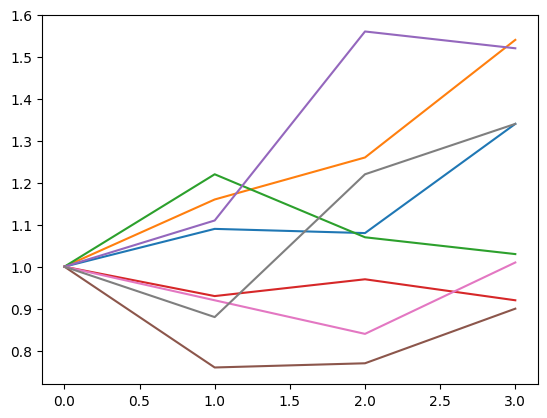

In [6]:
plot(t, X);

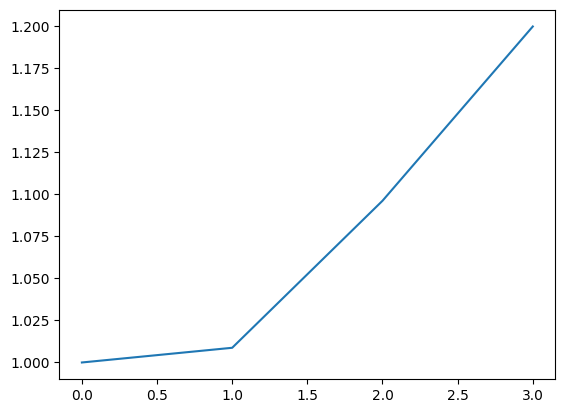

In [7]:
plot(t, X.mean(axis=1));

In [8]:
def exercise_value(s):
    return np.maximum(1.1 - s, 0)

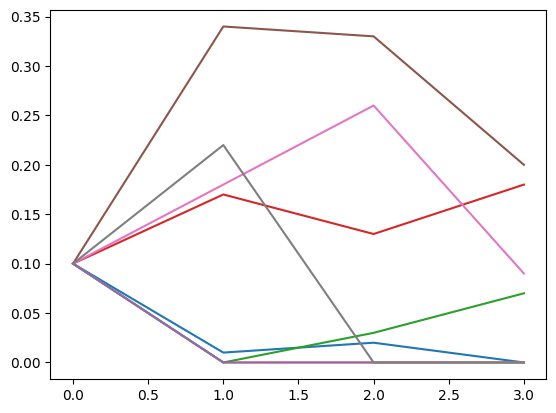

In [9]:
plot(t, exercise_value(X));

In [10]:
exercise_value(X[-1])

array([0.  , 0.  , 0.07, 0.18, 0.  , 0.2 , 0.09, 0.  ])

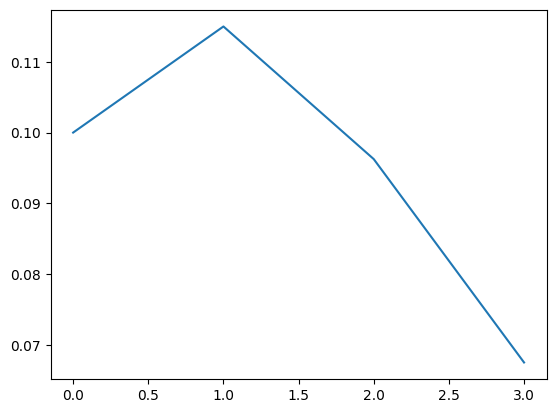

In [11]:
plot(t, exercise_value(X).mean(axis=1));

In [12]:
p = Polynomial([1, 1, 1, 1])
p

Polynomial([1., 1., 1., 1.], domain=[-1,  1], window=[-1,  1])

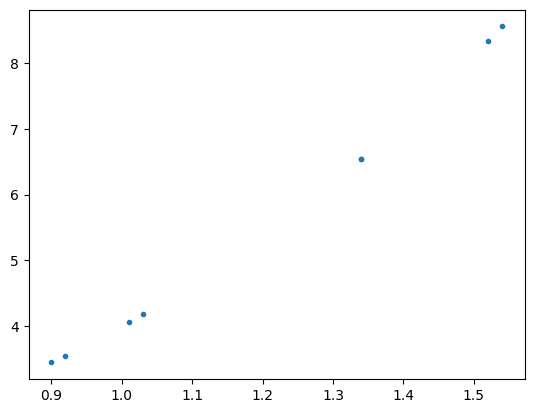

In [13]:
x = X[-1, :]
plot(x, p(x), ".");

In [14]:
def fit(x, y):
    return Polynomial.fit(x, y, 2)

In [15]:
p = fit(x, exercise_value(x))
p

Polynomial([ 0.00787132, -0.08933314,  0.0896597 ], domain=[0.9 , 1.54], window=[-1.,  1.])

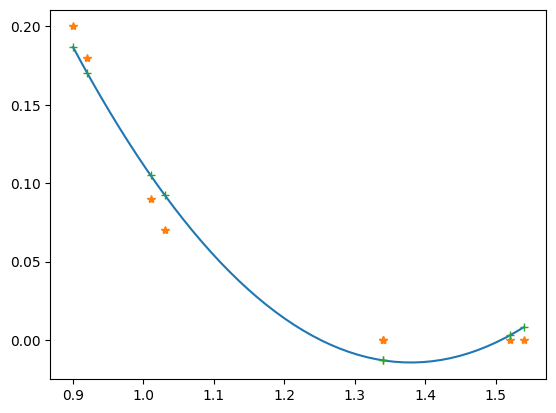

In [16]:
_x = np.linspace(np.min(x), np.max(x))
plot(_x, p(_x))
plot(x, exercise_value(x), "*")
plot(x, p(x), "+");

In [17]:
def backward_regression(fit, exercise_value, X, r):
    df = np.exp(-r)
    cashflow = exercise_value(X[-1, :])
    for i in reversed(range(1, X.shape[0] - 1)):
        cashflow = cashflow * df
        x = X[i, :]
        itm = exercise_value(x) > 0
        fitted = fit(x[itm], cashflow[itm])
        exercise = exercise_value(x)
        continuation = fitted(x)
        ex_idx = itm & (exercise > continuation)
        cashflow[ex_idx] = exercise[ex_idx]
        yield cashflow, x, fitted, continuation, exercise, ex_idx

In [18]:
bw_regr_steps = list(backward_regression(fit, exercise_value, X, r))

In [19]:
t = X.shape[0] - 2
for cashflow, x, fitted, continuation, exercise, ex_idx in backward_regression(
    fit, exercise_value, X, r
):
    print(f"Regression at t = {t}:")
    print(np.round(fitted.convert(domain=[-1, 1]).coef, 3))
    print(np.round(continuation, 4))
    print(ex_idx)
    print(np.round(cashflow, 3))
    print()
    t = t - 1

Regression at t = 2:
[-1.07   2.983 -1.814]
[ 0.0367 -0.1901  0.0459  0.1175 -0.8294  0.152   0.1564 -0.1296]
[False False False  True False  True  True False]
[0.    0.    0.066 0.13  0.    0.33  0.26  0.   ]

Regression at t = 1:
[ 2.038 -3.335  1.356]
[ 0.0135 -0.0064 -0.0128  0.1087  0.0065  0.2861  0.117   0.1528]
[False False False  True False  True  True  True]
[0.    0.    0.062 0.17  0.    0.34  0.18  0.22 ]



In [20]:
assert np.average(cashflow) * np.exp(-r) >= np.average(
    exercise_value(X[-1, :]) * np.exp(-3 * r)
)
print(np.round(np.average(cashflow) * np.exp(-r), 4))
print(np.round(np.average(exercise_value(X[-1, :])) * np.exp(-3 * r), 4))

0.1144
0.0564
